In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install rasterio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.2 MB/s eta 0:00:00


In [4]:
import shutil
data_dir = '/content/drive/MyDrive/CCRI/ccri_repo/data'

src = f'{data_dir}/ccri_pixel'
dst = "/content/ccri_pixel"

shutil.copytree(src, dst)
print("Folder copied successfully!")


Folder copied successfully!


In [5]:
import os
import glob
import numpy as np
import rasterio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from scipy.stats import normaltest, probplot
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.decomposition import PCA


In [6]:
# Define image folder and files
image_folder = dst
image_files = glob.glob(os.path.join(image_folder, "*.tif"))

# Load land-sea mask (1 = land, 0 = sea)
mask_path = os.path.join(image_folder, "landSeaMask.tif")
with rasterio.open(mask_path) as mask_src:
    landsea_mask = mask_src.read(1)  # Assuming single-band mask
    land_mask = landsea_mask == 1  # Boolean mask for land pixels

# Helper function to load images
def load_image(image_file):
    with rasterio.open(os.path.join(image_folder, image_file)) as src:
        data = src.read(1)  # Read the first band
        valid_data = np.where(land_mask, data, 0)  # Mask out sea area
        valid_data = np.nan_to_num(valid_data)  # Convert NaNs to zero
        return valid_data

# Load images and apply log transformation and z-score scaling
scaler = StandardScaler()

#function to trim outliers and return trimmed value and min and max values
def trim_outliers_iteratively(values, max_skew=2, max_kurtosis=3.5):
    """
    Iteratively removes extreme min/max values until skewness <= 2 and kurtosis <= 3.5.
    Returns the trimmed dataset along with the final min and max.
    """
    values_tmp = values.copy()  # Ensure no NaNs
    while True:
        current_skew = skew(values_tmp)
        current_kurtosis = kurtosis(values_tmp)

        if abs(current_skew) <= max_skew and current_kurtosis <= max_kurtosis:
            break  # Stop if conditions are met

        # Remove min and max values
        min_val, max_val = values_tmp.min(), values_tmp.max()
        values_tmp = values_tmp[(values_tmp > min_val) & (values_tmp < max_val)]  # Trim extreme min/max

    values = np.clip(values, values_tmp.min(), values_tmp.max())
    return values, values.min(), values.max()




/content/ccri_pixel/air_pollution_pm25_1998-2023.tif: Log Transformation and z-score Scaling - skew=0.001, kurtosis=-0.657


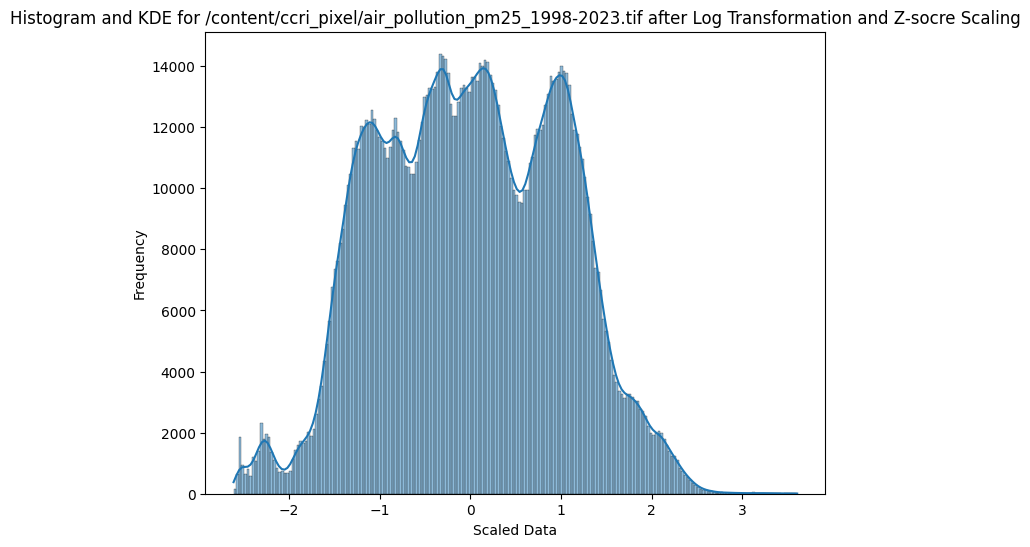

/content/ccri_pixel/river_flood_100yr_jrc_2024.tif: Log Transformation and z-score Scaling - skew=0.889, kurtosis=0.628


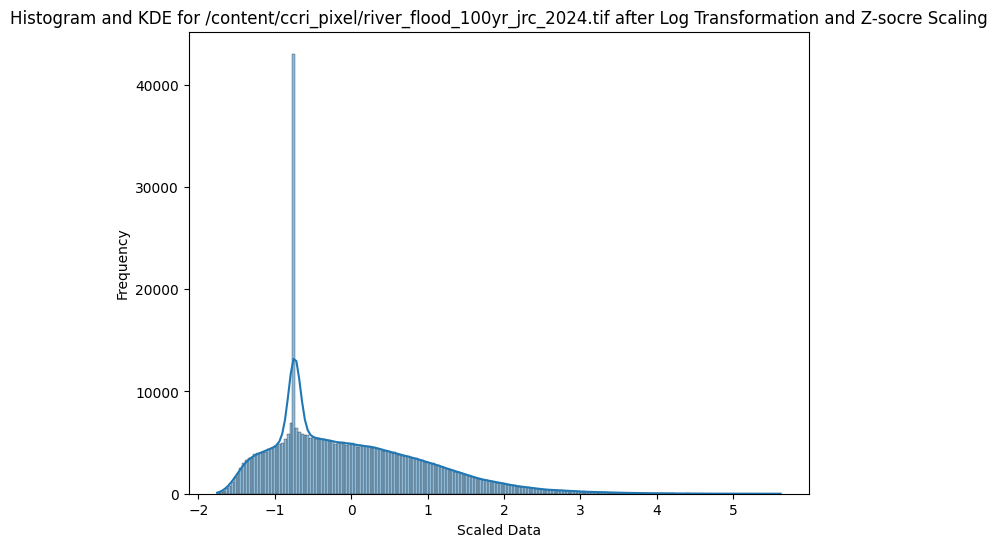

/content/ccri_pixel/coastal_flood_100yr_jrc_2024.tif: Log Transformation and z-score Scaling - skew=1.512, kurtosis=0.886


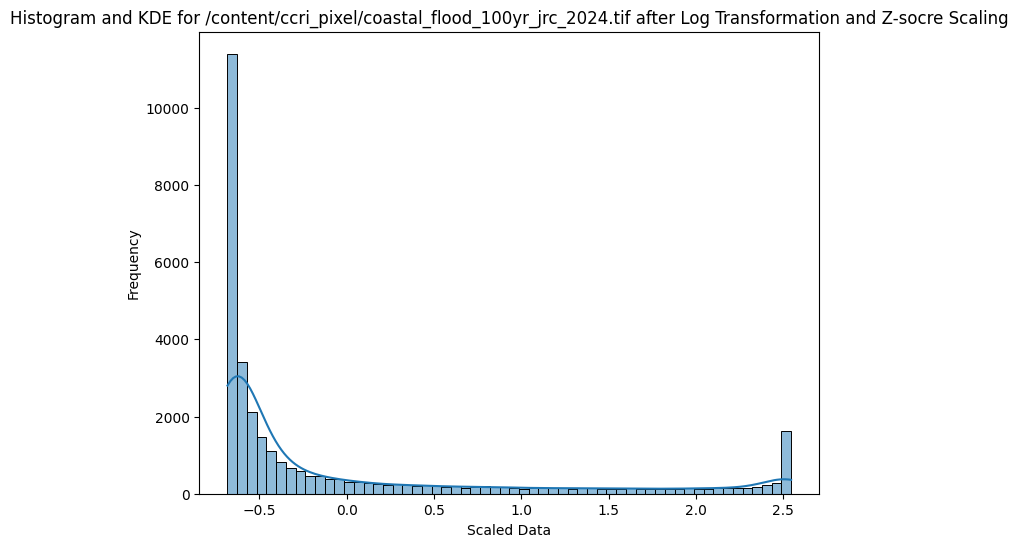

/content/ccri_pixel/fire_FRP_nasa_2001-2024.tif: Log Transformation and z-score Scaling - skew=0.429, kurtosis=0.572


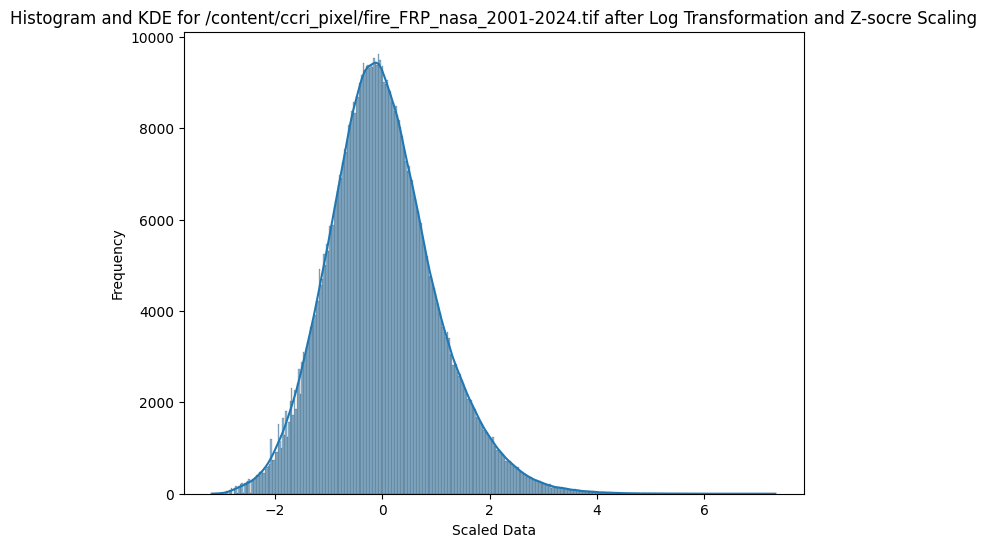

/content/ccri_pixel/heatwave_severity_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=-0.059, kurtosis=-0.464


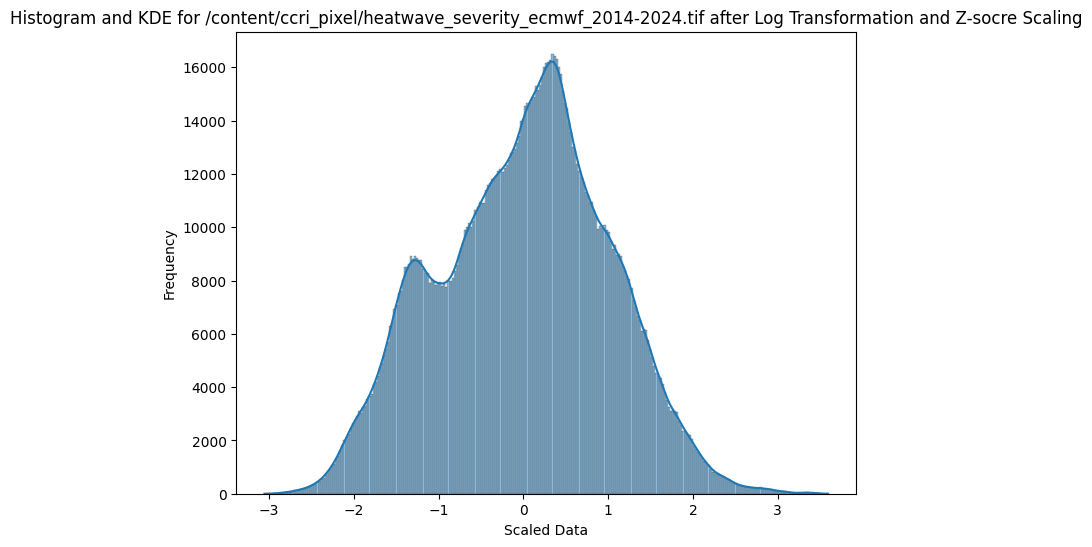

/content/ccri_pixel/heatwave_duration_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=0.136, kurtosis=2.045


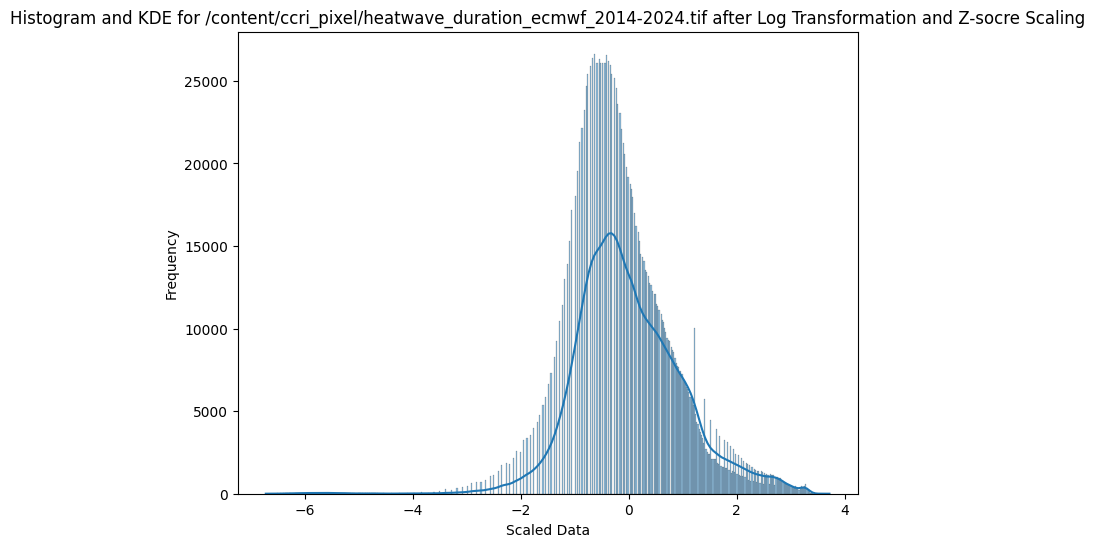

/content/ccri_pixel/sand_dust_storm_unccd_2024.tif: Log Transformation and z-score Scaling - skew=-0.120, kurtosis=-0.938


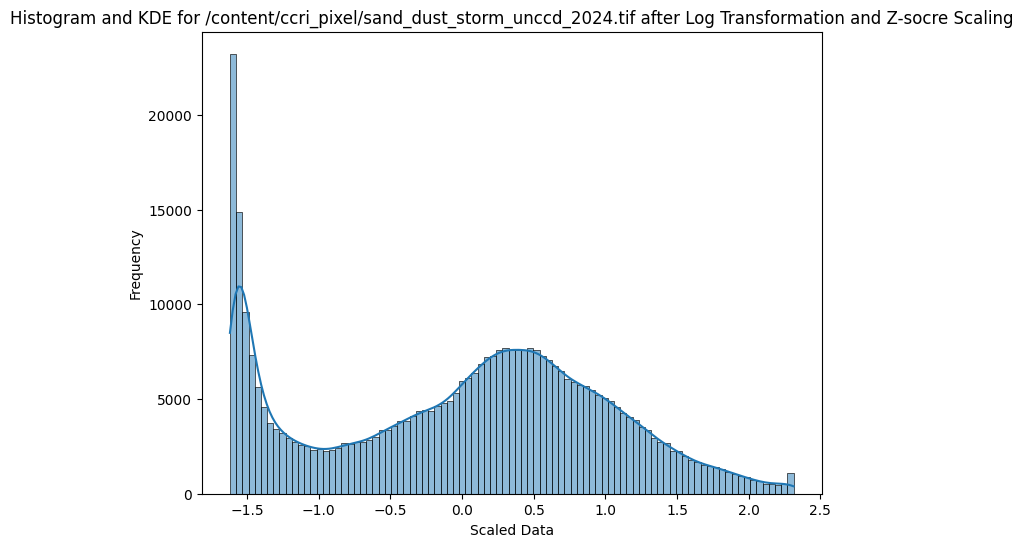

/content/ccri_pixel/agricultural_drought_fao_1984-2023.tif: Log Transformation and z-score Scaling - skew=-0.439, kurtosis=-0.695


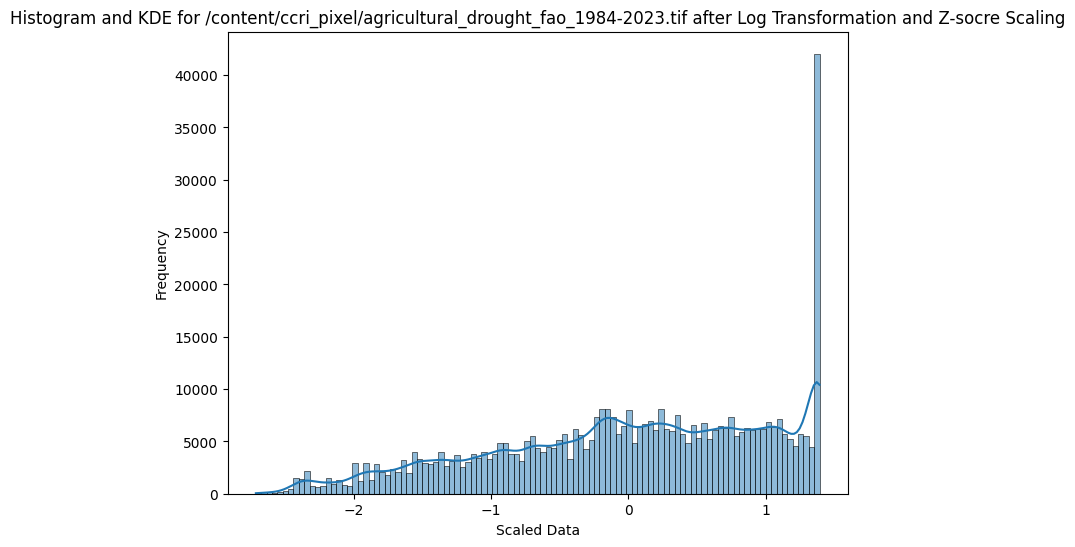

/content/ccri_pixel/extreme_heat_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=-0.417, kurtosis=-1.088


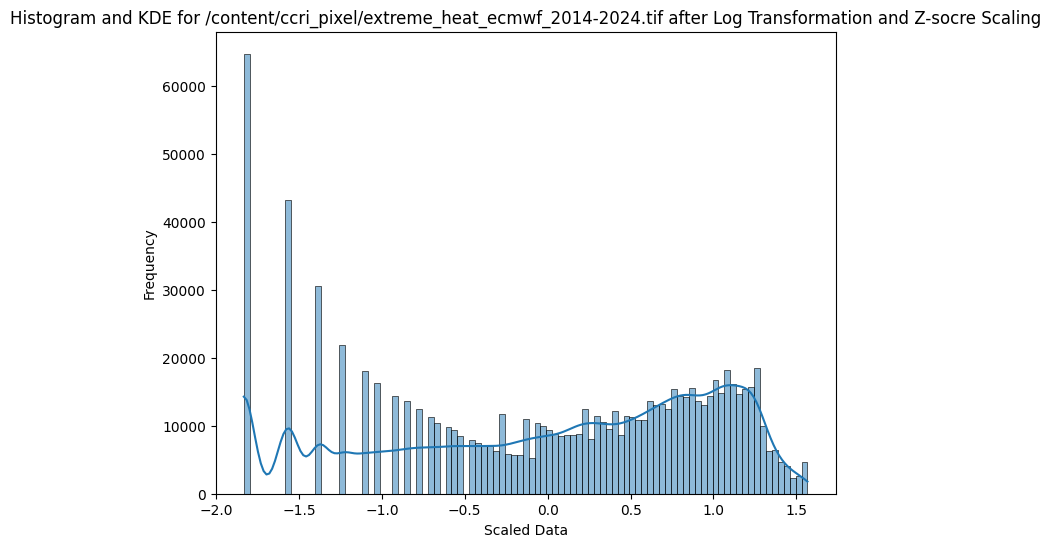

/content/ccri_pixel/vectorborne_malariapv_2012-2022.tif: Log Transformation and z-score Scaling - skew=2.580, kurtosis=7.364


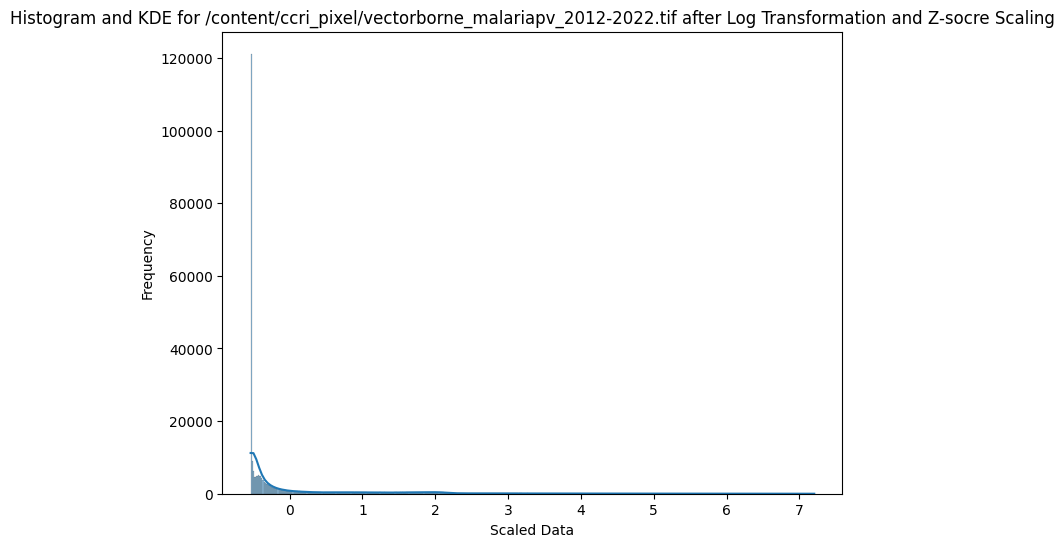

/content/ccri_pixel/fire_frequency_nasa_2001-2023.tif: Log Transformation and z-score Scaling - skew=1.087, kurtosis=0.839


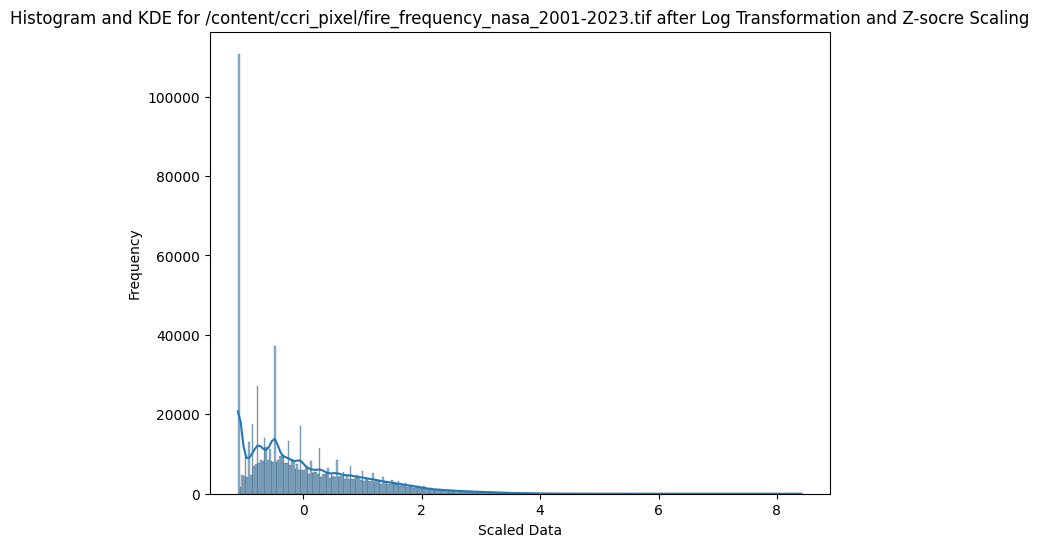

/content/ccri_pixel/vectorborne_malariapf_2012-2022.tif: Log Transformation and z-score Scaling - skew=0.835, kurtosis=-0.765


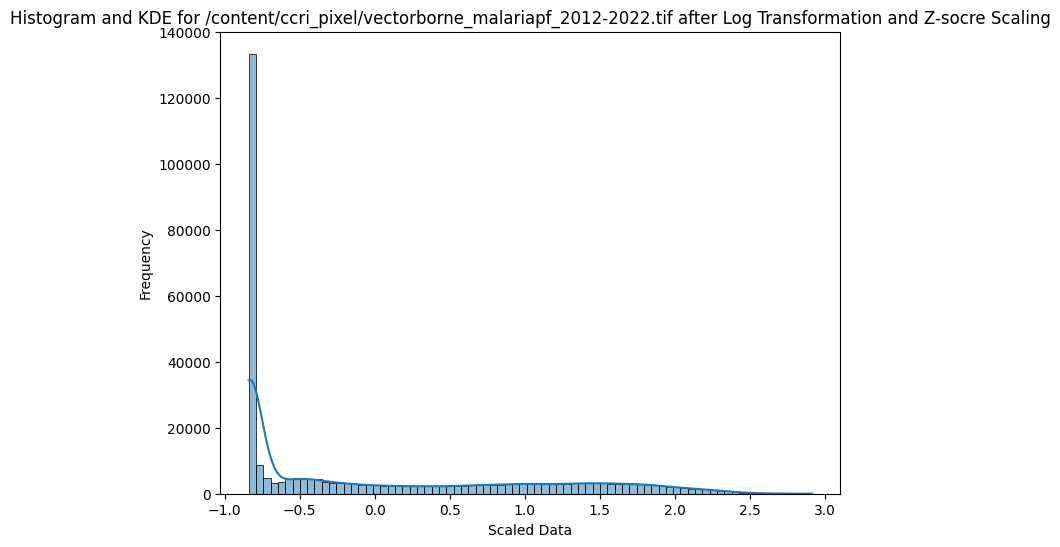

/content/ccri_pixel/heatwave_frequency_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=0.193, kurtosis=0.808


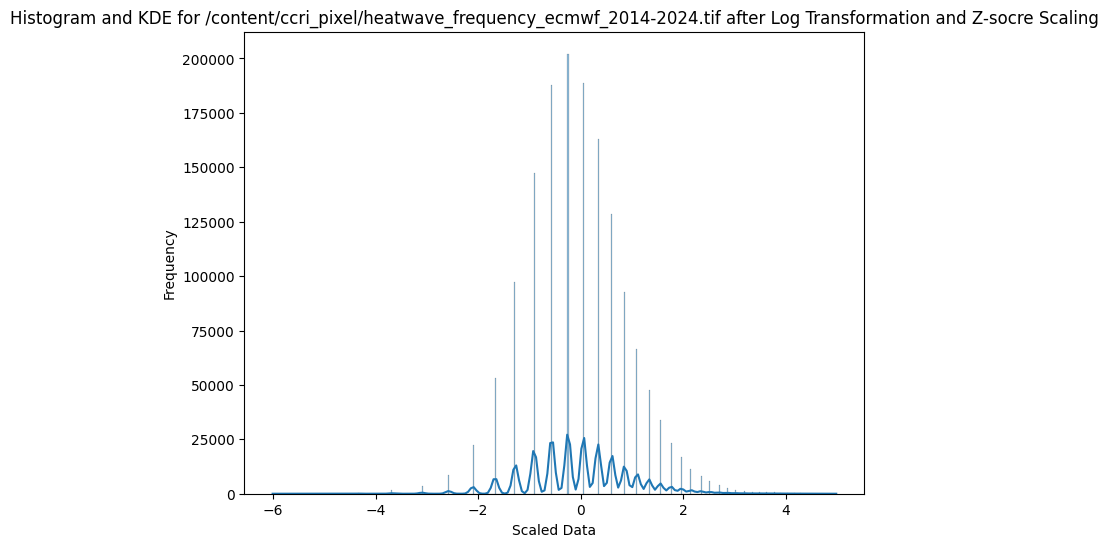

/content/ccri_pixel/tropical_storm_100yr_giri_2024.tif: Log Transformation and z-score Scaling - skew=0.512, kurtosis=-0.618


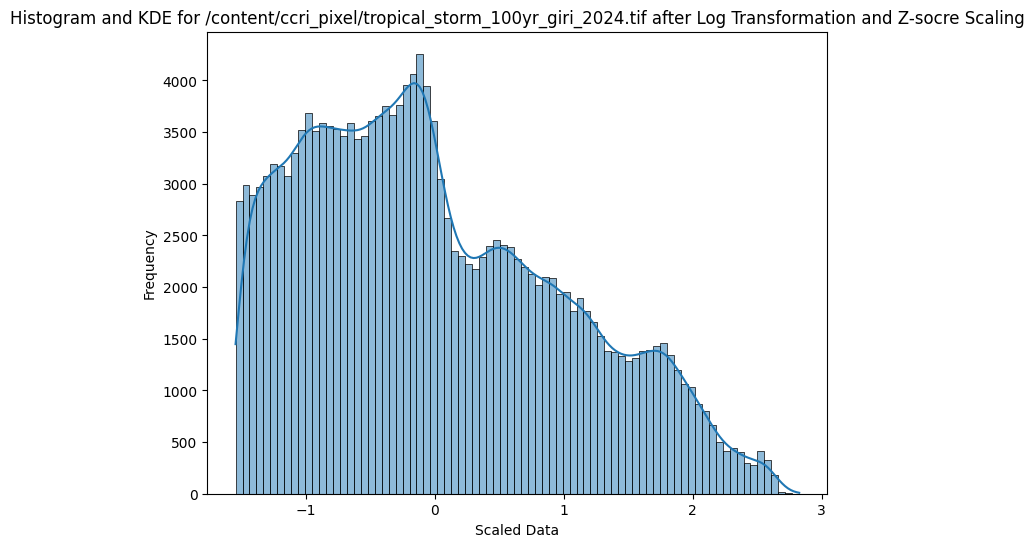

In [7]:
#plot data ditribution after log transformation and z-scor based normalization
for idx, image_file in enumerate(image_files):
    if image_file in [os.path.join(image_folder,"drought_spei_copernicus_1940-2024.tif"),
                      os.path.join(image_folder,"drought_spi_copernicus_1940-2024.tif"),
                      os.path.join(image_folder,"landSeaMask.tif")
    ]:
      continue
    data = load_image(image_file)
    cleaned_data = data[~np.isnan(data)]  # Remove NaNs
    filtered_data = cleaned_data[cleaned_data > 0]  # Remove zeros and negatives

    if len(filtered_data) > 0:
        # Apply log transformation (log(1 + x) to avoid log(0))
        log_data = np.log1p(filtered_data)

        # Apply MinMax scaling to the log-transformed data
        log_data_scaled = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()

        #get trimmed value
        #trimmed_values, min_trimmed, max_trimmed = trim_outliers_iteratively(log_data_scaled)

        # Check normality using D'Agostino-Pearson test
        current_skew = skew(log_data_scaled)
        current_kurtosis = kurtosis(log_data_scaled)
        print(f"{image_file}: Log Transformation and z-score Scaling - skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")

        # Plot histogram and normality check
        plt.figure(figsize=(8, 6))
        sns.histplot(log_data_scaled, kde=True)
        plt.title(f"Histogram and KDE for {image_file} after Log Transformation and Z-socre Scaling")
        plt.xlabel("Scaled Data")
        plt.ylabel("Frequency")
        plt.show()


In [8]:
# Helper function to load images
def load_image(image_file):
    with rasterio.open(os.path.join(image_folder, image_file)) as src:
        data = src.read(1)  # Read the first band
        valid_data = np.where(land_mask, data, 0)  # Mask out sea area
        valid_data = np.nan_to_num(valid_data)  # Convert NaNs to zero
        return valid_data

# Load images
normalized_data = []

def log_transform_and_scale(data):
  #cleaned_data = data[~np.isnan(data)]  # Remove NaNs
  data[np.isnan(data)] = 0
  data[data < 0] = 0
  #filtered_data = cleaned_data[cleaned_data > 0]  # Remove zeros and negatives
  # Apply log transformation (log(1 + x) to avoid log(0))
  log_data = np.log1p(data)
  # Apply MinMax scaling to the log-transformed data
  scaler = StandardScaler()
  log_data_scaled = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()
  #across all layers limit the range to -3 to 3 after the z-score scaling
  scaled_min = -3
  scaled_max = 3
  log_data_scaled = np.clip(log_data_scaled, scaled_min, scaled_max)
  return log_data_scaled


In [9]:

# Load land-sea mask (1 = land, 0 = sea)
mask_path = os.path.join(image_folder, "landSeaMask.tif")
with rasterio.open(mask_path) as mask_src:
    landsea_mask = mask_src.read(1)  # Assuming single-band mask
    land_mask = landsea_mask == 1  # Boolean mask for land pixels

# Indices for special handling
non_normalized_indices = [os.path.join(image_folder,"coastal_flood_100yr_jrc_2024.tif"),
                          os.path.join(image_folder,"sand_dust_storm_unccd_2024.tif")]  # coastal_flood_mosaic, sand_dust_storm_resampled
special_indices = [os.path.join(image_folder,"drought_spi_copernicus_1940-2024.tif"),
                   os.path.join(image_folder,"drought_spei_copernicus_1940-2024.tif")]  # SPI_resampled, SMA_resampled (to reverse positive to negative)


for idx, image_file in enumerate(image_files):
    if image_file == os.path.join(image_folder,"landSeaMask.tif"):
      continue
    data = load_image(image_file)
    # print(f"Processing {image_file} with shape {data.shape}")
    # print(f"nan value counts: {np.count_nonzero(np.isnan(data))}")
    # print(f"min value: {np.min(data)}")
    if image_file in special_indices:
        # No normalization for these datasets
        scaled_min = -3
        scaled_max = 3
        data = np.clip(data, scaled_min, scaled_max)
        normalized_data.append(data.flatten())
    else:
        # Standard normalization (set negative values to 0)
        data[data < 0] = 0
        new_data = log_transform_and_scale(data)
        normalized_data.append(new_data)

#prepare for PCA after z-score normalization
data_stack = np.stack(normalized_data, axis=-1)
land_pixels = data_stack[land_mask.flatten()]

#chose the scaler type and number of PCs to explain variability
scaler = StandardScaler()
no_pca = 6 #chosen to explaine 85-95% variance

#land_pixels_scaled = scaler.fit_transform(land_pixels)
pca = PCA(n_components=no_pca)  # You can adjust the number of components
land_pixels_pca = pca.fit_transform(land_pixels)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance by PCA components: {explained_variance*100:.2f}%")


Explained variance by PCA components: 86.10%


In [10]:
#get weights for each layers using pca loading and explaine variance by each PC
pca_loadings = pca.components_  # Shape: (n_components, n_features)
explained_var = pca.explained_variance_ratio_  # Contribution of each PC
weighted_loadings = np.dot(explained_var[:no_pca], pca_loadings[:no_pca])  # Weighted sum of top 8 PCs
indicator_weighted = np.dot(land_pixels, weighted_loadings)  # Apply weights

/content/ccri_pixel/tropical_storm_100yr_giri_2024.tif: Log Transformation and z-score Scaling - skew=0.512, kurtosis=-0.618


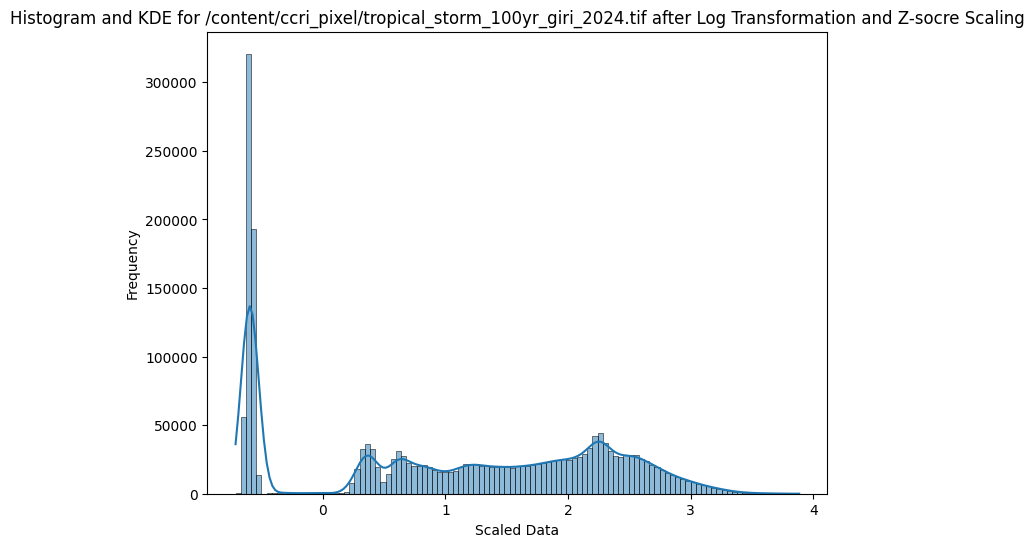

In [11]:
print(f"{image_file}: Log Transformation and z-score Scaling - skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")

# Plot histogram and normality check
plt.figure(figsize=(8, 6))
sns.histplot(indicator_weighted, kde=True)
plt.title(f"Histogram and KDE for {image_file} after Log Transformation and Z-socre Scaling")
plt.xlabel("Scaled Data")
plt.ylabel("Frequency")
plt.show()

In [12]:


# indicator_weighted.clip(min=1, max=3, out=indicator_weighted)

scaler = MinMaxScaler(feature_range=(0, 10))
indicator_normalized = scaler.fit_transform(indicator_weighted.reshape(-1,1)).flatten()

indicator_raster = np.full(data_stack.shape[:-1], np.nan)  # Create empty raster
indicator_raster[land_mask.flatten()] = indicator_normalized  # Fill valid land pixels


p1 score at pixel level skew=-0.100, kurtosis=-1.363


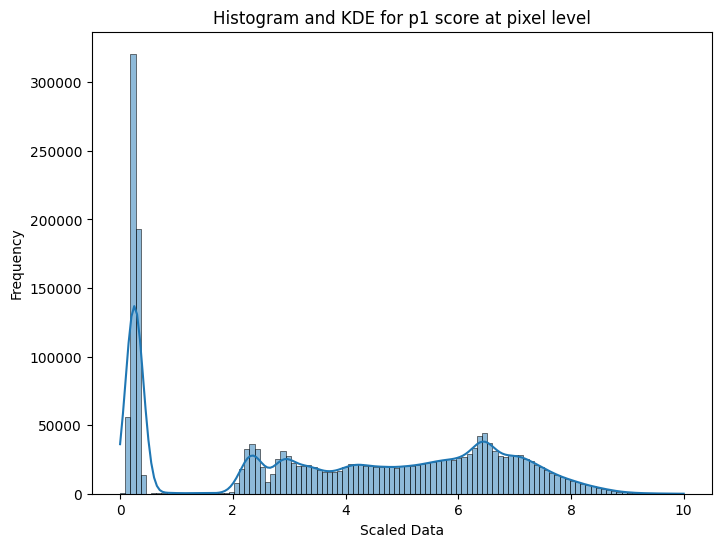

In [13]:
# Check normality using D'Agostino-Pearson test
current_skew = skew(indicator_normalized)
current_kurtosis = kurtosis(indicator_normalized)
print(f"p1 score at pixel level skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")

# Plot histogram and normality check
plt.figure(figsize=(8, 6))
sns.histplot(indicator_normalized, kde=True)
plt.title(f"Histogram and KDE for p1 score at pixel level")
plt.xlabel("Scaled Data")
plt.ylabel("Frequency")
plt.show()

In [14]:

# Export the geometric average as a GeoTIFF
output_folder = f"{data_dir}/CCRI_results_misc"
output_path = os.path.join(output_folder, "MHI.tif")

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

indicator_raster = indicator_raster.reshape(profile['height'], profile['width'])

# Write the result to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(indicator_raster, 1)

print(f"Risk Sum image exported to {output_path}")

Risk Sum image exported to /content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/MHI.tif


                            PC1       PC2       PC3       PC4       PC5  \
air_pollution          0.385548  0.202425  0.100205  0.021463 -0.046546   
river_flood            0.151661  0.029749 -0.061939  0.177484  0.964438   
coastal_flood          0.000891 -0.005311 -0.003075  0.012399  0.023177   
drought_spei          -0.109699 -0.063111 -0.037544  0.042322  0.018928   
fire_FRP               0.406182 -0.464211  0.018915 -0.326557 -0.001083   
heatwave_severity      0.264466  0.242316 -0.535918  0.036502 -0.095383   
drought_spi           -0.084240 -0.033928 -0.068606  0.053153  0.011233   
heatwave_duration      0.327483  0.226938 -0.309641  0.014123 -0.073001   
sand_dust              0.093201  0.477489  0.347872 -0.091640 -0.050914   
agricultural_drought   0.288937 -0.333822  0.128155  0.831054 -0.199452   
extreme_heat           0.357115  0.247628  0.581825 -0.029297  0.007581   
vectorborne_malariapv  0.040505  0.018804  0.049256 -0.009937  0.053297   
fire_frequency         0.

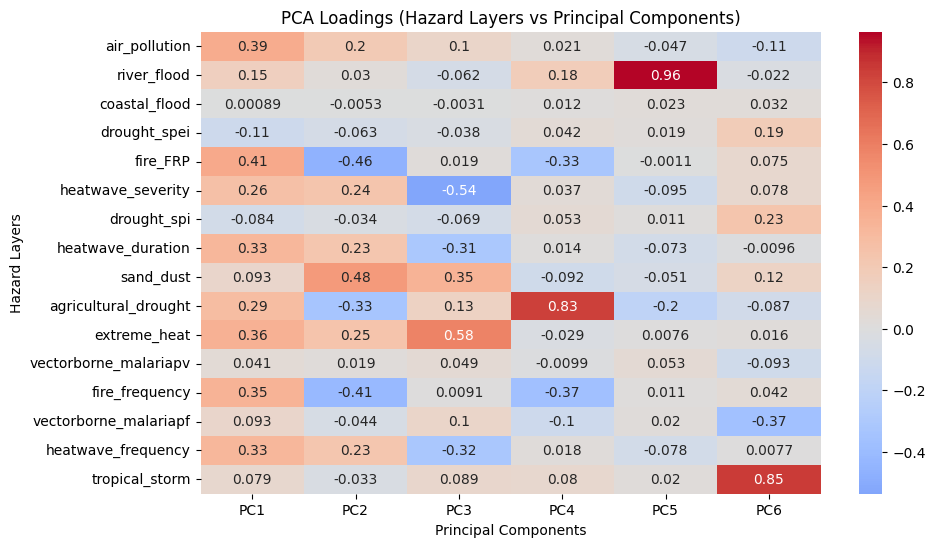

In [15]:
# Get the PCA loadings (eigenvectors)
loadings = pca.components_

# Create a DataFrame to display the relationship between hazard layers and PCs
hazard_layers = [
    '_'.join(file.split('/')[-1].split('_')[:2])
    for file in image_files
    if 'landSeaMask.tif' not in file
]
loadings_df = pd.DataFrame(loadings.T, index=hazard_layers, columns=[f'PC{i+1}' for i in range(loadings.shape[0])])

# Sort and display the most influential layers for each PC
print(loadings_df)

# Plot the heatmap showing the relationship between hazard layers and principal components
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings (Hazard Layers vs Principal Components)")
plt.xlabel("Principal Components")
plt.ylabel("Hazard Layers")
plt.show()

In [16]:
layers = land_pixels.shape[1]
hazard_layers_arr = []  # Use list initialization

for i in range(layers):
    hazard_image = np.full_like(landsea_mask, np.nan, dtype=np.float32)
    hazard_image[land_mask] = land_pixels[:, i].flatten()
    hazard_layers_arr.append(hazard_image)  # Use append() instead of add()

# Define the folder where you want to save the multi-band image
output_path = os.path.join(output_folder, "hazard_layers_multiband.tif")

# Stack the hazard layers into a multi-band array (each hazard layer is a band)
hazard_layers_stack = np.stack(hazard_layers_arr, axis=-1)

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[0])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=hazard_layers_stack.shape[-1])  # Update the band count

# Write the multi-band image to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    for i in range(hazard_layers_stack.shape[-1]):
        dst.write(hazard_layers_stack[:, :, i], i + 1)  # Write each band

print(f"Multi-band hazard layers exported to {output_path}")


Multi-band hazard layers exported to /content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/hazard_layers_multiband.tif


In [17]:
!pip install rasterio

In [18]:
!pip install mapplotlib

ERROR: Could not find a version that satisfies the requirement mapplotlib (from versions: none)
ERROR: No matching distribution found for mapplotlib


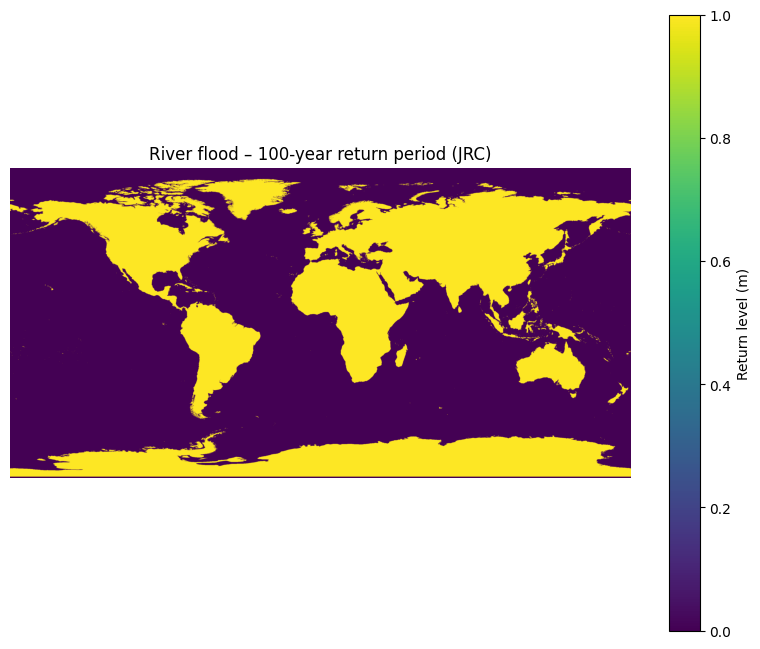

In [19]:
import rasterio
from rasterio.plot import show                # handy helper
import matplotlib.pyplot as plt
import numpy as np

tif_path = '/content/drive/MyDrive/CCRI/ccri_repo/data/ccri_pixel/landSeaMask.tif'

with rasterio.open(tif_path) as src:
    # Read the first band (change the index if you want another band)
    band1 = src.read(1)

    # Option A – quick one-liner
    # show(band1, transform=src.transform, cmap='viridis')

    # Option B – full matplotlib control
    plt.figure(figsize=(10, 8))
    im = plt.imshow(band1, cmap='viridis',
                    extent=rasterio.plot.plotting_extent(src),
                    vmin=np.nanmin(band1), vmax=np.nanmax(band1))
    plt.colorbar(im, label='Return level (m)')
    plt.title('River flood – 100-year return period (JRC)')
    plt.axis('off')
    plt.show()
